BERT fine-tuning for sentiment analysis. 

### Install the TensorFlow Model Garden pip package

*  `tf-models-official` is the stable Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` github repo. To include latest changes, you may install `tf-models-nightly`,
which is the nightly Model Garden package created daily automatically.
*  pip will install all models and dependencies automatically.

In [1]:
!pip install -q -U "tensorflow==2.8.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.6 MB/s eta 0:00:00


In [2]:
!pip install -q tf-models-official==2.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 5.0 MB/s eta 0:00:00


### Imports

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
#import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


### Resources

This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

You can get a pre-trained BERT encoder from [TensorFlow Hub](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2):

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

##The Data

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds

imdb, info = tfds.load('imdb_reviews', 
                       with_info=True,
                       split=('train[:60%]', 'train[60%:]', 'test'), 
                       as_supervised=True)

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [7]:
temp_imdb = tfds.as_numpy(imdb[0])
temp_imdb = list(temp_imdb)
print(len(temp_imdb))

elem, label = temp_imdb[0]
print(elem)
print(f"label: {label}")

15000
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label: 0


In [8]:
imdb_train, imdb_validation, imdb_test = imdb

In [9]:
def convert_to_dict_format(data):
  reviews = []
  labels = []
  
  for r, l in data:
    reviews.append(r.numpy())
    labels.append(l.numpy())
  
  return {'reviews': reviews, 'labels':labels}

In [10]:
imdb_train = convert_to_dict_format(imdb_train.take(1000))
imdb_validation = convert_to_dict_format(imdb_validation.take(500))
imdb_test = convert_to_dict_format(imdb_test.take(500))

### The BERT tokenizer

To finetune a pre-trained model you need to be sure that you're using exactly the same tokenization, vocabulary, and index mapping as you used during pretraining.

The following code rebuilds the tokenizer that was used by the base model:

In [11]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


Tokenize a sentence:

In [12]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


### Preprocess the data

Let's manually preprocess the dataset into the format expected by the model.

This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token:

In [13]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Start by encoding all the sentences while appending a `[SEP]` token, and packing them into ragged-tensors:

In [14]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

max_sent_length = 500  # limit to 150 characters
reviews = tf.ragged.constant([encode_sentence(s[:max_sent_length]) for s in imdb_train['reviews']])

In [15]:
print("Reviews shape:", reviews.shape.as_list())

Reviews shape: [1000, None]


Now prepend a `[CLS]` token, and concatenate the ragged tensors to form a single `input_word_ids` tensor for each example. 

In [16]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)

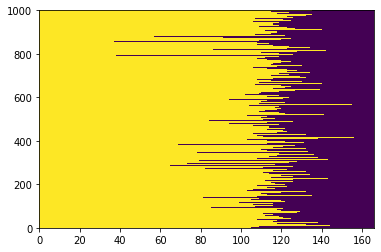

In [17]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

#### Put it all together

In [18]:
len(imdb_train["reviews"])

1000

In [19]:
imdb_train['reviews'][0]

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [20]:
imdb_train['reviews'][0][:max_sent_length]

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but"

In [21]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

print(encode_sentence(imdb_train['reviews'][0][:max_sent_length], tokenizer))

[2023, 2001, 2019, 7078, 6659, 3185, 1012, 2123, 1005, 1056, 2022, 26673, 1999, 2011, 5696, 3328, 2368, 2030, 2745, 3707, 7363, 1012, 2119, 2024, 2307, 5889, 1010, 2021, 2023, 2442, 3432, 2022, 2037, 5409, 2535, 1999, 2381, 1012, 2130, 2037, 2307, 3772, 2071, 2025, 2417, 21564, 2023, 3185, 1005, 1055, 9951, 9994, 1012, 2023, 3185, 2003, 2019, 2220, 3157, 7368, 2149, 10398, 3538, 1012, 1996, 2087, 17203, 5019, 2020, 2216, 2043, 1996, 25882, 8431, 2020, 2437, 2037, 3572, 2005, 25239, 1012, 3814, 9530, 5428, 2696, 17649, 2596, 6887, 16585, 1010, 1998, 2014, 18404, 1011, 2293, 6771, 2007, 3328, 2368, 2001, 2498, 2021, 102]


The following code does:

*   Adds the special symbol [CLS]
*   Sentence padding 
*   Adds mask for the special symbols 
*   Adds a mask for the token position 

In [35]:
def bert_encode(imdb, tokenizer):
  num_examples = len(imdb['reviews'])
  
  review = tf.ragged.constant([
      encode_sentence(s[:max_sent_length], tokenizer)
      for s in imdb["reviews"]])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * review.shape[0]
  input_word_ids = tf.concat([cls, review], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.ones_like(review)
  
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()
  
  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [36]:
imdb_train_enc = bert_encode(imdb_train, tokenizer)
imdb_train_labels = np.array(imdb_train['labels'])

imdb_validation_enc = bert_encode(imdb_validation, tokenizer)
imdb_validation_labels = np.array(imdb_validation['labels'])

imdb_test_enc = bert_encode(imdb_test, tokenizer)
imdb_test_labels  = np.array(imdb_test['labels'])

In [40]:
imdb_train_enc['input_word_ids'][0]

<tf.Tensor: shape=(166,), dtype=int32, numpy=
array([  101,  2023,  2001,  2019,  7078,  6659,  3185,  1012,  2123,
        1005,  1056,  2022, 26673,  1999,  2011,  5696,  3328,  2368,
        2030,  2745,  3707,  7363,  1012,  2119,  2024,  2307,  5889,
        1010,  2021,  2023,  2442,  3432,  2022,  2037,  5409,  2535,
        1999,  2381,  1012,  2130,  2037,  2307,  3772,  2071,  2025,
        2417, 21564,  2023,  3185,  1005,  1055,  9951,  9994,  1012,
        2023,  3185,  2003,  2019,  2220,  3157,  7368,  2149, 10398,
        3538,  1012,  1996,  2087, 17203,  5019,  2020,  2216,  2043,
        1996, 25882,  8431,  2020,  2437,  2037,  3572,  2005, 25239,
        1012,  3814,  9530,  5428,  2696, 17649,  2596,  6887, 16585,
        1010,  1998,  2014, 18404,  1011,  2293,  6771,  2007,  3328,
        2368,  2001,  2498,  2021,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

Each subset of the data has been converted to a dictionary of features, and a set of labels. Each feature in the input dictionary has the same shape, and the number of labels should match:

In [41]:
for key, value in imdb_train_enc.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'imdb_train_labels shape: {imdb_train_labels.shape}')

input_word_ids  shape: (1000, 166)
input_mask      shape: (1000, 166)
input_type_ids  shape: (1000, 166)
imdb_train_labels shape: (1000,)


## The model

### Build the model


The first step is to download the configuration  for the pre-trained model.


In [42]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The `config` defines the core BERT Model, which is a Keras model to predict the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

This function returns both the encoder and the classifier.

In [43]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=2)

The classifier has three inputs and one output:

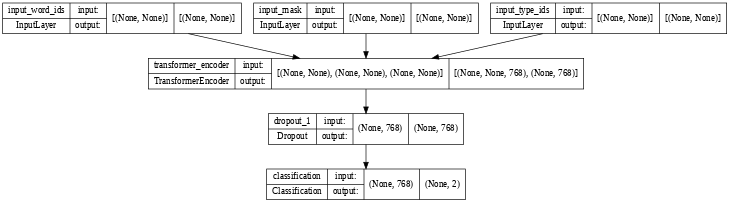

In [44]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

Inspecting the encoder, we see its stack of `Transformer` layers connected to those same three inputs:

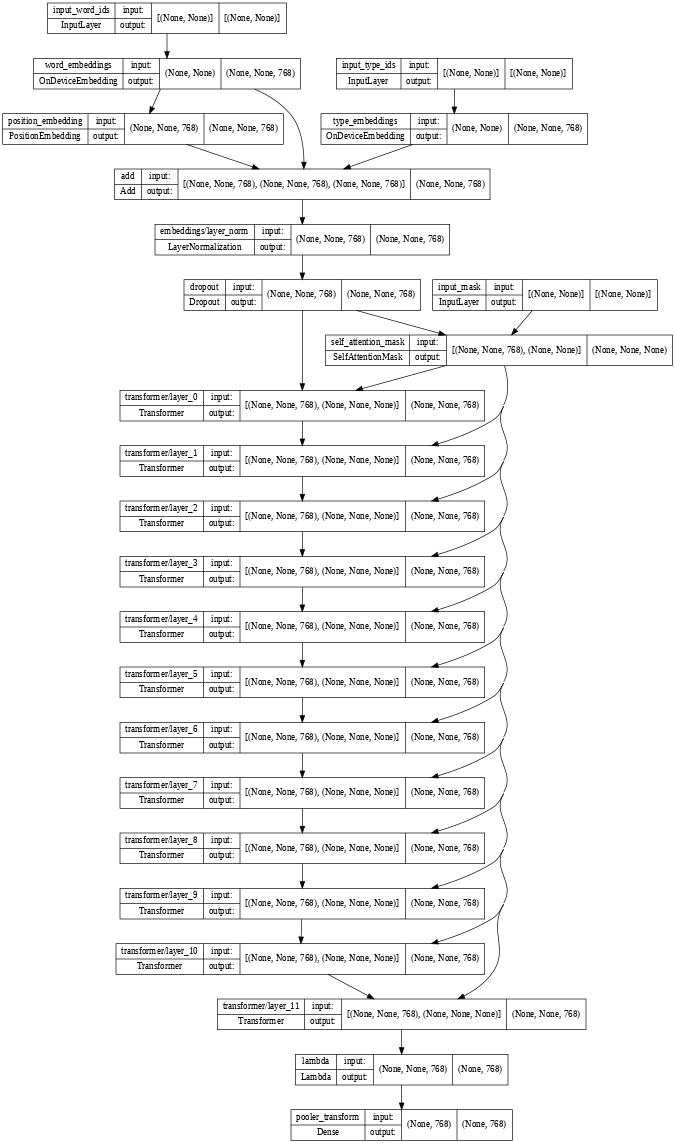

In [45]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights

When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [46]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pretrained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). See the [Hub appendix](#hub_bert) for details. 

### Set up the optimizer

BERT adopts the Adam optimizer with weight decay (aka "[AdamW](https://arxiv.org/abs/1711.05101)").
It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0.

In [48]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(imdb_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

This returns an `AdamWeightDecay`  optimizer with the learning rate schedule set:

### Train the model

The metric is accuracy and we use sparse categorical cross-entropy as loss.

In [49]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      imdb_train_enc, imdb_train_labels,
      validation_data=(imdb_validation_enc, imdb_validation_labels),
      batch_size=batch_size,
      epochs=epochs)

Epoch 1/3
32/32 [==============================] - 60s 1s/step - loss: 0.6771 - accuracy: 0.5650 - val_loss: 0.6174 - val_accuracy: 0.7140
Epoch 2/3
32/32 [==============================] - 41s 1s/step - loss: 0.5439 - accuracy: 0.7790 - val_loss: 0.4535 - val_accuracy: 0.8280
Epoch 3/3
32/32 [==============================] - 40s 1s/step - loss: 0.4050 - accuracy: 0.8630 - val_loss: 0.4123 - val_accuracy: 0.8460


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

The model should report class `1` "match" for the first example and class `0` "no-match" for the second:

In [50]:
result = bert_classifier(imdb_test_enc, training=False)

In [51]:
result = tf.argmax(result, axis=1).numpy()

In [52]:
from sklearn.metrics import classification_report

print(classification_report(imdb_test_labels, result, target_names=info.features['label'].names))

              precision    recall  f1-score   support

         neg       0.84      0.88      0.86       251
         pos       0.87      0.83      0.85       249

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500

